In [271]:
import geopandas as gp
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import fiona
from shapely import wkt
import pyproj
import contextily as cx

In [2]:
#pd.set_option('display.max_colwidth', None)

## TASK 1

## overlapping.csv plot

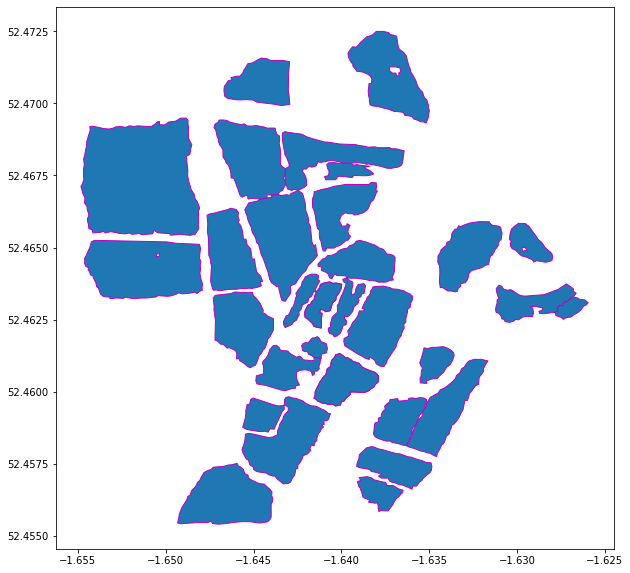

In [137]:
# plot of overlapping.csv 
overlapping = pd.read_csv("data/overlapping.csv")
from shapely import wkt

overlapping['geometry'] = overlapping['Agrimetrics Geometry'].apply(wkt.loads)
gdf = gp.GeoDataFrame(overlapping, crs='epsg:4326')
gdf.plot(figsize=(10, 10), edgecolor='m')
plt.savefig('plots/overlapping.png')

## outwood plot

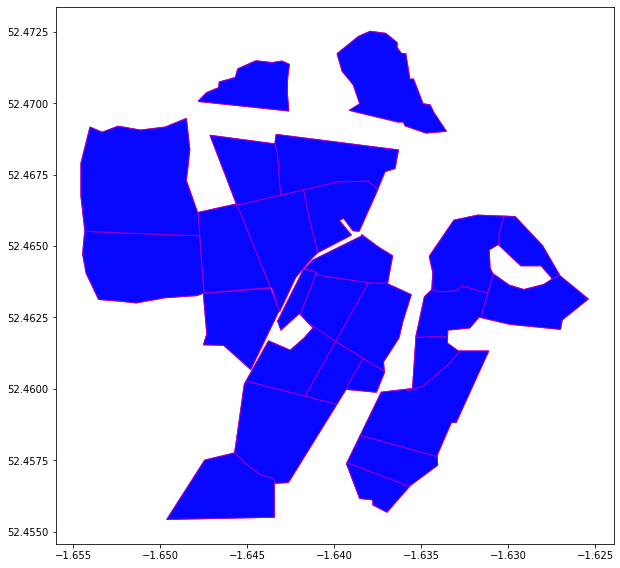

In [138]:
# # Read ground truth data
gt = gp.read_file("data/Outwoods_Warren.shx")
gt.shape

gt = gt.rename({'Field': 'field_name', 'Farm': 'farm'}, axis = 'columns')
gt_clean = gt.replace(['w_', '_2_f', '_1_f', 'sp_', '_cl'],'', regex=True)
gt_clean.crs

# Transform data and only keep data from 2018 onwards, since the predictions are covering (2018-2022)
ground_truth_per_year = pd.melt(gt_clean, id_vars=['id', 'farm', 'field_name', 'area', 'area_has', 'geometry'],
                                value_vars=['2018', '2019','2020', '2021', '2022'])

ground_truth_per_year.columns = ['id', 'farm', 'field_name', 'area', 'area_has', 'geometry', 'year', 'gt_label']
ground_truth_per_year.head(10)
ground_truth_per_year.plot(figsize=(10, 10), alpha=0.5, edgecolor='m', color="blue")
plt.savefig('plots/outwood.png')

In [75]:
sym_diff = gp.read_file("sym_diff_area.shp")
diff_area = sym_diff['diff_area'].sum()
diff_area

106178.81000000001

## TASK 2

In [272]:
gt_pred_clipped = gp.read_file("gt_pred_clipped.shp")
gt_pred_clipped['field_name'] = gt_pred_clipped['Field'].apply(lambda x: x.split('-')[0])
gt_pred_clipped = gt_pred_clipped.drop(['Field'], axis =1)
gt = gt_pred_clipped.rename({'Field': 'field_name', 'Farm': 'farm'}, axis = 'columns')
gt_clean = gt.replace(['w_', '_2_f', '_1_f', 'sp_', '_cl'],'', regex=True)
# Transform data and only keep data from 2018 onwards, since the predictions are covering (2018-2022)
ground_truth_per_year = pd.melt(gt_clean, id_vars=['id', 'farm', 'field_name', 'area', 'area_has', 'geometry'],
                                value_vars=['2018', '2019','2020', '2021', '2022'])
ground_truth_per_year.columns = ['id', 'farm', 'field_name', 'area', 'area_has', 'geometry', 'year', 'gt_label']



ground_truth_per_year = ground_truth_per_year.replace(['clover', 'oats' , 'cover_oats' , 'diverse_cover'], 
                                                      'grass', regex=False)
ground_truth_per_year = ground_truth_per_year.replace(['fallow' , 'environ' , 'beans'], 
                                                      'unknown', regex=False)
ground_truth_per_year = ground_truth_per_year.replace(['osr'], 'oilseed',  regex=False)
                                        

In [273]:
predictions = pd.read_csv("data/predictions.csv")
predictions.columns = ['agrimetrics_id', 'prediction_date', 'barley', 'wheat', 'unknown', 'oilseed', 'grass', 'field_name']
min_date = predictions["prediction_date"].min()
max_date = predictions["prediction_date"].max()
#print(min_date, max_date)

predictions['prediction_date'] =  pd.to_datetime(predictions['prediction_date'])
predictions['field_name'] = predictions['field_name'].apply(lambda x: x.split('-')[0])
predictions['year'] = pd.DatetimeIndex(predictions['prediction_date']).year

# get the column name of max values in every row and set that as the predicted label
crops_cols = ['barley', 'wheat', 'unknown', 'oilseed', 'grass']
crops = predictions[crops_cols]
maxValueIndexObj = crops.idxmax(axis=1)
print("Max crop probability of row are:")
predictions['predicted_label'] = maxValueIndexObj
predictions = predictions.drop(predictions.columns[[2,3,4,5,6]], axis = 1)
predictions.head(1)
#predictions[predictions['field_name'] == 'Blacksmiths'].head()



Max crop probability of row are:


,agrimetrics_id,prediction_date,field_name,year,predicted_label
0,https://data.agrimetrics.co.uk/fields/eKukN2a1...,2018-06-15 00:00:00+00:00,Blacksmiths,2018,barley


## merging predictions and ground truths together to run the comparison

In [274]:
frames = [predictions, ground_truth_per_year]
predictions.head(10)
#ground_truth_per_year.head(10)
ground_truth_per_year['year']=ground_truth_per_year['year'].astype(int)
predictions['year']=predictions['year'].astype(int)
pred_gt = ground_truth_per_year.merge(predictions, left_on=['field_name', 'year'], right_on=['field_name', 'year'] )
pred_gt.head(1)
pred_gt['gt_label']=pred_gt['gt_label'].astype(str)
pred_gt['predicted_label']=pred_gt['predicted_label'].astype(str)



pred_gt['tp'] = pred_gt.gt_label.eq(pred_gt.predicted_label) | pred_gt.gt_label.isna() & pred_gt.predicted_label.isna()
pred_gt['tp'] 
pred_gt.loc[pred_gt.drop('id', axis=1).isna().sum(axis=1).groupby(pred_gt['id']).transform(lambda g: g if g.shape[0] > 1 else 0).astype(bool), 'tp'] = ''

pred_gt.shape[0] # (160, 12)
pred_gt.groupby(['tp']).size()

over_accuracy = (49 * 100 / 160) 
over_accuracy


30.625

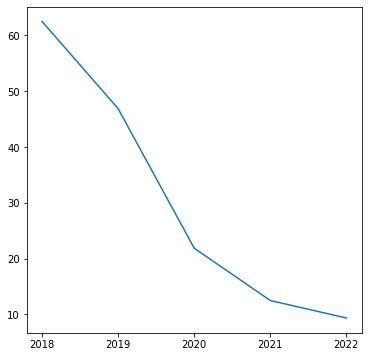

In [352]:
years = ["2018", "2019", "2020", "2021", "2022"]

accuracy_yoy = {}
for i in years:

    year = int(i)
    df = pred_gt[pred_gt['year'] == year]
    total_pred = df.shape[0]
    tp = df.groupby(['tp']).size()[1]
    accuracy = tp * 100 / total_pred

    accuracy_yoy[i] = accuracy

accuracy_yoy
lists = sorted(accuracy_yoy.items())
lists
x, y = zip(*lists) # unpack a list of pairs into two tuples


plt.subplots(figsize=(6, 6))

plt.plot(x, y)
plt.savefig('plots/accuracy_yoy.png')


## TASK 3

In [353]:
# The question is not very clear, on what is the reason behind the coarse resolution, why is the degree of resoution that we are looking for
# Normally in such tasks you would look if there are other images from different temporal resolution and interpolate the missing parts
# Or there are techniques such as super-resolution using convolutional networks